# MVRegFus: Stitching

Notebook to test stitching / tiling of many tif stacks.

- Create test data
- Write to tifs
- Run registration and fusion

In [1]:
%matplotlib widget
import mvregfus
from mvregfus import multiview
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage
from dask import array as da
import tifffile

In [2]:
from pathlib import Path
import numpy as np
from aicsimageio import AICSImage
from aicspylibczi import CziFile

files = [
'/home/malbert/projects/stitching/data/WT_emb2_20X_part1_Scene-2-TR3.czi',
# '/mnt/gaia/gros_stitching_project/arthur_20220621_premovie_dish2-max.czi',
# '/mnt/gaia/gros_stitching_project/arthur_20220609_WT_emb2_5X_part1_max.czi',
]

In [3]:
# from aicspylibczi import CziFile
# from aicsimageio import AICSImage


# io_utils = importlib.reload(io_utils)

# view_dict = io_utils.build_view_dict_from_multitile_czi(files[0])
# view_dict
# # pairs = mv_utils.get_registration_pairs_from_view_dict(view_dict)
# # pairs, view_dict
# # im = read_tile_from_multitile_czi(files[0], tile_index=1, channel_index=0, time_index=0)
# # plt.figure()
# # plt.imshow(im)
# # plt.scatter([0],[1])

In [3]:
from aicspylibczi import CziFile
from aicsimageio import AICSImage

import importlib
from mvregfus import io_utils, mv_utils
io_utils = importlib.reload(io_utils)
mv_utils = importlib.reload(mv_utils)

view_dict = io_utils.build_view_dict_from_multitile_czi(files[0])
# view_dict
pairs = mv_utils.get_registration_pairs_from_view_dict(view_dict)
pairs#, view_dict
# im = read_tile_from_multitile_czi(files[0], tile_index=1, channel_index=0, time_index=0)
# plt.figure()
# plt.imshow(im)
# plt.scatter([0],[1])

PylibCZI_CDimCoordinatesUnderspecifiedException: The coordinates are underspecified = you have not specified a Dimension that is required. More than 1 tile matched. Be more specific.

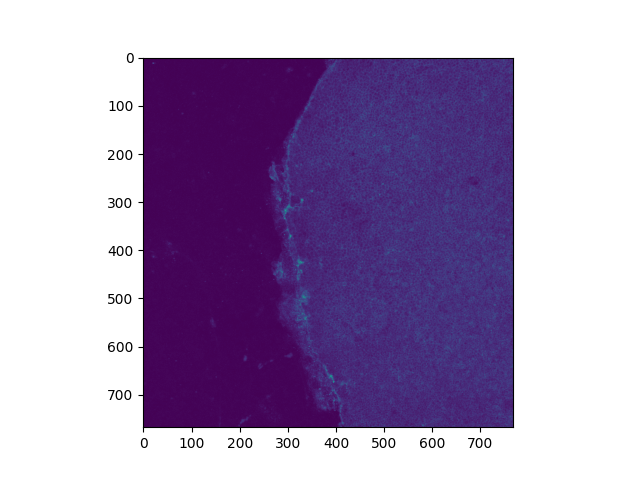

In [6]:
im = io_utils.read_tile_from_multitile_czi(files[0], tile_index=5, channel_index=0, time_index=0)
plt.figure()
plt.imshow(im)

In [48]:
%%capture

from mvregfus import mv_graph, io_utils, mv_utils

import importlib
mv_graph = importlib.reload(mv_graph)
io_utils = importlib.reload(io_utils)
mv_utils = importlib.reload(mv_utils)
multiview = importlib.reload(multiview)

filename = files[0]
view_dict = io_utils.build_view_dict_from_multitile_czi(filename)
pairs = mv_utils.get_registration_pairs_from_view_dict(view_dict)
pairs = [(0,5)]

ndim = len(view_dict[0]['shape'])

graph = {}
for t in range(1):

    outdir = '/tmp'

    # build dask graph
    graph.update(
        mvregfus.mv_graph.build_multiview_graph(
            out_dir=outdir,
            ndim=ndim,
            filepath=None,
            channels=[0, 1],
            reg_channel=0,
            perform_chromatic_correction=False,
            mv_registration_bin_factors=[2]*ndim,
            mv_final_spacing=view_dict[0]['spacing'],
            pairs=pairs,
            view_dict=view_dict,
            fusion_method='weighted_average',
            fusion_weights='blending',
            elastix_dir='/home/malbert/software/elastix',
            pairwise_registration_mode=None, # 0: translation registration using elastix
            final_volume_mode='union',
            debug_pairwise_registration=True,
            background_level=0,
            sample=t,
            time_alignment=False,
            time_alignment_ref_view=0,
            multitile_czi=True,
        )
    )

# compute dask graph
keys = [k for k in graph.keys() if k.startswith('mv_transf')]
# keys = [k for k in graph.keys() if k.startswith('view_full')]
# o = io_utils.get(graph, keys, local=True)
# graph
print(keys)

In [49]:
from dask.diagnostics import ProgressBar
# with ProgressBar():

import importlib

mv_utils = importlib.reload(mv_utils)
io_utils = importlib.reload(io_utils)
multiview = importlib.reload(multiview)

o = io_utils.get(graph, keys, local=True)
o

[[ 1  2  1 ...  3  2  2]
 [ 2  1  2 ...  2  4  2]
 [ 2  1  1 ...  1  3  2]
 ...
 [ 2  2  2 ... 37 42 35]
 [ 2  2  2 ... 31 35 37]
 [ 3  3  3 ... 44 52 41]]
[[ 4  4  2 ... 33 27 32]
 [ 3  3  3 ... 41 30 33]
 [ 3  3  3 ... 31 33 34]
 ...
 [ 4  3  2 ... 30 32 34]
 [ 4  3  2 ... 42 28 31]
 [ 3  3  3 ... 38 30 38]]
DECORATOR local... register_linear_elastix
producing /tmp/mv_params_000_000_vfix000_vmov005.prealignment.h5
compute clahe with kernel size 10
compute clahe with kernel size 10
REGSPACING [4.41942708 4.41942708]
DECORATOR local... calc_stack_properties_from_views_and_params
DECORATOR local... get_params_from_pairs
producing /tmp/mv_params0_000_000.prealignment.h5
weights:  (0, 5) 4.0 [1. 0. 0. 1. 0. 0.]
DECORATOR local... concatenate_view_and_time_params
processing PATH for view 5:  [0, 5]
[[0, 5]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
DECORATOR local... concatenate_view_and_time_params
[array([1., 0., 0., 1., 0., 0.]), array([1., 0., 0., 1., 0., 0.])]
DECORATOR local... calc_stack

('/tmp/mv_transf_view_000_000_v000_c00.image.ims',
 '/tmp/mv_transf_view_000_000_v005_c00.image.ims',
 '/tmp/mv_transf_view_000_000_v000_c01.image.ims',
 '/tmp/mv_transf_view_000_000_v005_c01.image.ims')

In [47]:
rm /tmp/mv_*

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.51it/s]


(<Figure size 988.8x604.8 with 3 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f81468bddf0>)

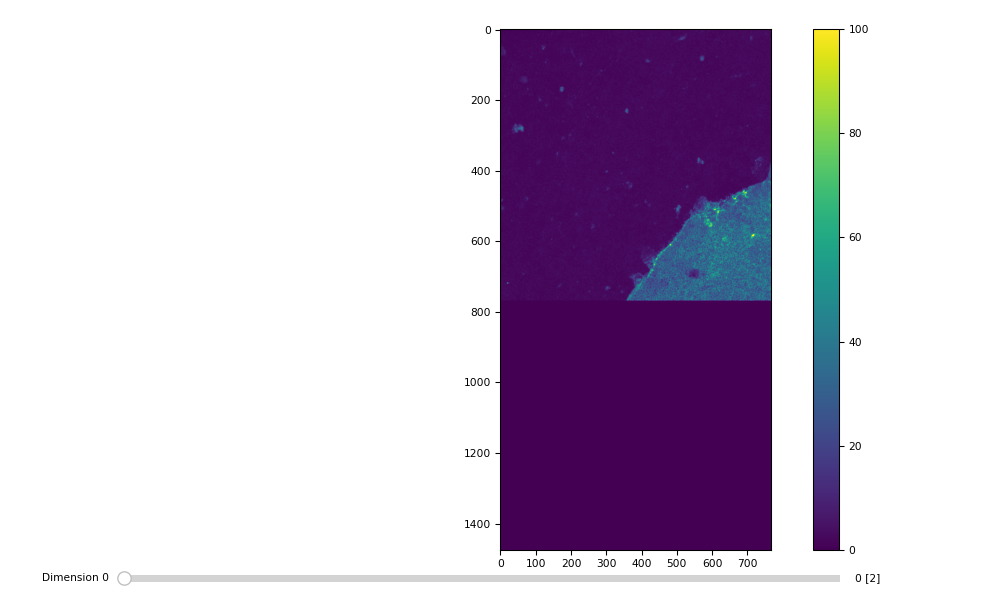

In [51]:
imt = []
from tqdm import tqdm
import h5py, os
min_shape = np.array([50000, 50000])
chs = [0]
for t in tqdm(range(1)):
    tim = []
    for ch in chs:
    
        fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in [0,5]]
        ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])

        w = np.sum(ims!=0, 0)
        w[w==0]=1
        im = np.sum(ims, 0)/w
        tim.append(im)
        
    imt.append(np.array(tim))
    min_shape = np.min([min_shape, im.shape],0)
    
imt = np.array([i[:, :min_shape[0], :min_shape[1]] for i in imt])

# tifffile.imshow(imt, vmin=0, vmax=100)
tifffile.imshow(np.array(ims), vmin=0, vmax=100)

In [2]:
%%capture

from mvregfus import mv_graph, io_utils, mv_utils

import importlib
mv_graph = importlib.reload(mv_graph)
io_utils = importlib.reload(io_utils)
mv_utils = importlib.reload(mv_utils)
multiview = importlib.reload(multiview)

fn = files[0]

graph = {}
for t in range(1):

    px_overlap_between_stacks = 30

    # specify input views
    view_dict = dict()
    fp = '/home/malbert/projects/stitching/data/highmag/highmag_max_t%(t)03d_ch%(ch)s_%(tile)01d.tif'

    tiles = range(1, 9)

    # def tile_index_to_gridpos(iind):
    #     if iind <=2: return ((0, iind))
    #     elif iind <=5: return ((1, 5-iind))
    #     else: return ((2, iind-6))
    
    def tile_index_to_gridpos(iind):
        if iind <=3: return ((0, iind))
        else: return ((1, 3 - (iind - 4)))

    xy_shape = None
    for iind, tile in enumerate(tiles):
        view_dict[iind] = dict()
        view_dict[iind]['view'] = iind # view identifier
        view_dict[iind]['filename'] = fp %{'tile': tile, 't':t, 'ch':"%(ch)02d"}
        if xy_shape is None:
            xy_shape = np.array(tifffile.imread(fp %{'tile': tile, 't':t, 'ch':"00"}).shape)
            xy_shape = np.array(list(xy_shape))
            # xy_shape = np.array(io_utils.)
        view_dict[iind]['spacing'] = np.ones(2)
        view_dict[iind]['rotation'] = 0 # all tiles have same rotation angle
        view_dict[iind]['shape'] = xy_shape

        view_dict[iind]['origin'] = np.array(tile_index_to_gridpos(iind)) * \
                                    np.array(tuple(xy_shape[:])) \
                                    - 2 * np.array(tile_index_to_gridpos(iind)) * px_overlap_between_stacks

    pairs = [(ii,ij) for ii, i in enumerate(tiles)
             for ij, j in enumerate(tiles)
             if np.sum(np.abs(np.array(tile_index_to_gridpos(ii))-np.array(tile_index_to_gridpos(ij)))) == 1 and ii<ij]

    outdir = '/home/malbert/projects/stitching/data/highmag/out'

    # build dask graph
    graph.update(
        mvregfus.mv_graph.build_multiview_graph(
            out_dir=outdir,
            ndim=2,
            filepath=None,
            channels=[0],
            reg_channel=0,
            perform_chromatic_correction=False,
            mv_registration_bin_factors=[2, 2],
            mv_final_spacing=[1,1],
            pairs=pairs,
            view_dict=view_dict,
            fusion_method='weighted_average',
            fusion_weights='blending',
        #     fusion_weights='dct',
            elastix_dir='/home/malbert/software/elastix',
            pairwise_registration_mode=None, # 0: translation registration using elastix
            final_volume_mode='union',
            debug_pairwise_registration=True,
            background_level=0,
            sample=t,
            time_alignment=False,
            time_alignment_ref_view=0,
        )
    )

# compute dask graph
keys = [k for k in graph.keys() if k.startswith('mv_transf')]
# keys = [k for k in graph.keys() if k.startswith('view')]
# o = io_utils.get(graph, keys, local=True)
# graph
print(keys)

In [3]:
from dask.diagnostics import ProgressBar
# with ProgressBar():

import importlib

mv_utils = importlib.reload(mv_utils)
io_utils = importlib.reload(io_utils)

o = io_utils.get(graph, keys, local=False)

[[13 12 11 ... 24 16 15]
 [10 10 12 ... 32 28 23]
 [11 12 20 ... 37 29 31]
 ...
 [25 33 36 ... 17 36 42]
 [37 42 40 ... 15 25 40]
 [51 49 41 ... 10 16 25]]
[[15 18 24 ... 31 32 26]
 [12 15 20 ... 29 25 28]
 [14 20 19 ... 20 25 22]
 ...
 [14 13 14 ... 23 16 13]
 [14 12 15 ... 15 12 10]
 [17 15 21 ... 14 10 10]]
DECORATOR local... register_linear_elastix
producing /home/malbert/projects/stitching/data/highmag/out/mv_params_000_000_vfix000_vmov001.prealignment.h5
compute clahe with kernel size 10
compute clahe with kernel size 10
DECORATOR local... calc_stack_properties_from_views_and_params
[[51 38 20 ...  3  2  2]
 [45 46 41 ...  2  3  2]
 [46 51 53 ...  3  2  3]
 ...
 [22  8 10 ...  3  3  3]
 [18  7  9 ...  3  3  3]
 [13  5  7 ...  2  3  3]]
DECORATOR local... register_linear_elastix
producing /home/malbert/projects/stitching/data/highmag/out/mv_params_000_000_vfix001_vmov002.prealignment.h5
compute clahe with kernel size 10
compute clahe with kernel size 10
DECORATOR local... calc_sta

In [ ]:
imt = []
from tqdm import tqdm
import h5py
min_shape = np.array([50000, 50000])
chs = [0]
for t in tqdm(range(1)):
    tim = []
    for ch in chs:
    
        fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in range(8)]
        ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])

        w = np.sum(ims!=0, 0)
        w[w==0]=1
        im = np.sum(ims, 0)/w
        tim.append(im)
        
    imt.append(np.array(tim))
    min_shape = np.min([min_shape, im.shape],0)
    
imt = np.array([i[:, :min_shape[0], :min_shape[1]] for i in imt])

tifffile.imshow(imt, vmin=0, vmax=100)

In [4]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
a=

In [ ]:
rm -r /home/malbert/Downloads/stitching/mvregfus1_max

In [ ]:
ls /home/malbert/Downloads/stitching/mvregfus1

In [ ]:
# from mvregfus import mv_graph, io_utils, mv_utils

# import importlib
# mv_graph = importlib.reload(mv_graph)
# io_utils = importlib.reload(io_utils)
# mv_utils = importlib.reload(mv_utils)
# multiview = importlib.reload(multiview)

# n_tiles_per_dim = 5
# px_overlap_between_stacks = 30

# # specify input views
# view_dict = dict()
# # for iind, ind in enumerate(np.ndindex(x.numblocks)):
# fp = '/home/malbert/Downloads/stitching/emb_9/tif_planes/f_%(tile)01d_t%(t)03d_c%(ch)03d.tif'

# tiles = range(1, 9)

# def tile_index_to_gridpos(iind):
#     if iind <=3: return ((0, iind))
#     else: return ((1, 7-iind))

# xy_shape = None
# for iind, tile in enumerate(tiles):
#     view_dict[iind] = dict()
#     view_dict[iind]['view'] = iind # view identifier
#     view_dict[iind]['filename'] = fp %{'tile': tile, 't':1, 'ch':1}
#     if xy_shape is None:
#         xy_shape = np.array(tifffile.imread(view_dict[iind]['filename']).shape)
#         # xy_shape = np.array(io_utils.)
#     view_dict[iind]['spacing'] = np.ones(3)
#     view_dict[iind]['rotation'] = 0 # all tiles have same rotation angle
#     view_dict[iind]['shape'] = np.array((10,) + tuple(xy_shape))
    
#     view_dict[iind]['origin'] = np.array((0,)+tile_index_to_gridpos(iind)) * \
#                                 np.array((0,) + tuple(xy_shape)) \
#                                 - 2 * np.array((0,)+tile_index_to_gridpos(iind)) * px_overlap_between_stacks

# pairs = [(ii,ij) for ii, i in enumerate(tiles)
#          for ij, j in enumerate(tiles)
#          if np.sum(np.abs(np.array(tile_index_to_gridpos(ii))-np.array(tile_index_to_gridpos(ij)))) == 1]

# # pairs = pairs[:1]

# # build dask graph
# graph = mvregfus.mv_graph.build_multiview_graph(
#     out_dir='/home/malbert/Downloads/stitching/mvregfus1',
#     filepath=None,
#     channels=[0],
#     mv_registration_bin_factors=[1,1,1],
#     mv_final_spacing=[1,1,1],
#     pairs=pairs,
#     view_dict=view_dict,
#     fusion_method='weighted_average',
#     fusion_weights='blending',
# #     fusion_weights='dct',
#     elastix_dir='/home/malbert/software/elastix',
#     pairwise_registration_mode=0, # 0: translation registration using elastix
#     final_volume_mode='union',
#     debug_pairwise_registration=True,
#     background_level=0,
# )

# # compute dask graph
# o = io_utils.get(graph, mv_graph.multiview_fused_label %(0, 0, 0), local=True)
# # graph

In [ ]:
res = o.compute()#scheduler='single-threaded')

In [ ]:
%debug

In [ ]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
h5py.File('

In [ ]:
tifffile.imshow(res)

In [ ]:
1

(<Figure size 988.8x604.8 with 4 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f6bfcba50d0>)

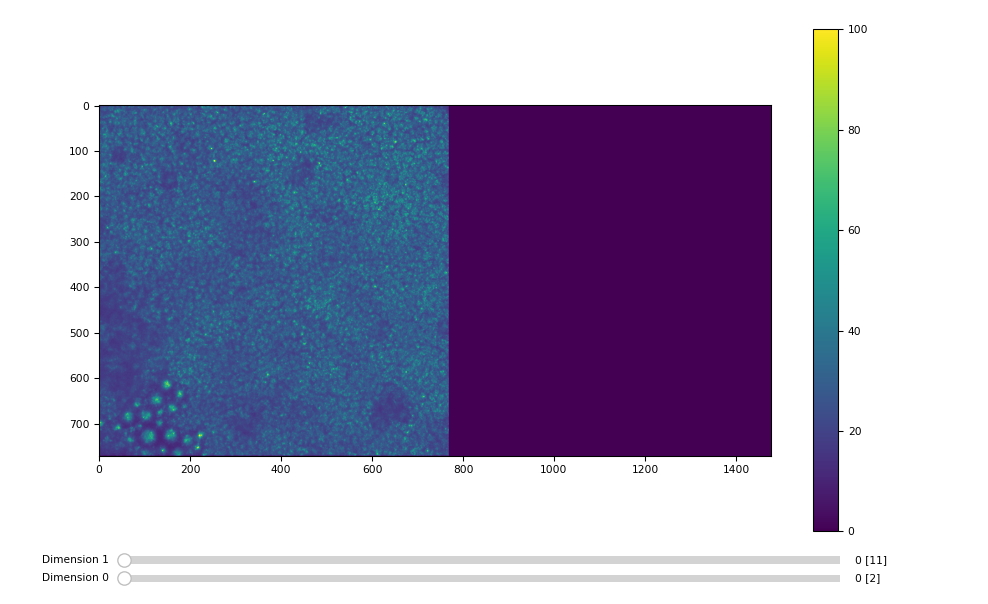

In [ ]:
import h5py
h5py.File('/home/malbert/projects/stitching/data/3d_mvregfus_2/mv_params_000_000_vfix000_vmov001.prealignment.h5')['prealignment'][()]
fns_tview = ['/home/malbert/projects/stitching/data/3d_mvregfus_2/mv_transf_view_000_000_v%03d_c02.image.ims' %v for v in range(2)]

ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])
tifffile.imshow(ims, vmin=0, vmax=100)

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fc2499b6b50>)

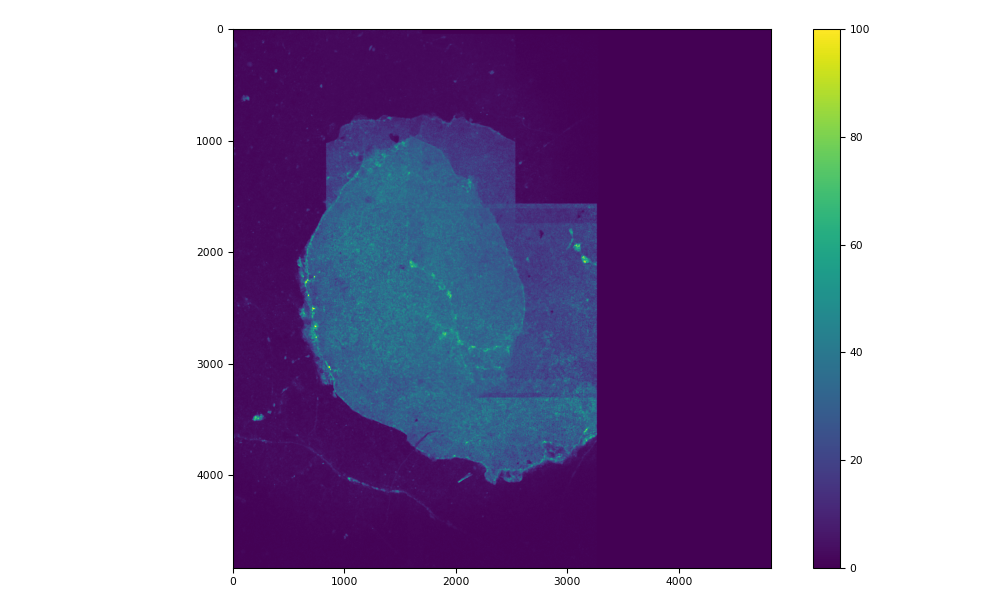

In [117]:
imt = []
from tqdm import tqdm
import h5py
min_shape = np.array([50000, 50000])
chs = [0]
for t in tqdm(range(1)):
    tim = []
    for ch in chs:
    
        fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in range(8)]
        ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])

        w = np.sum(ims!=0, 0)
        w[w==0]=1
        im = np.sum(ims, 0)/w
        tim.append(im)
        
    imt.append(np.array(tim))
    min_shape = np.min([min_shape, im.shape],0)
    
imt = np.array([i[:, :min_shape[0], :min_shape[1]] for i in imt])

tifffile.imshow(imt, vmin=0, vmax=100)

In [ ]:
tifffile.imsave("/home/malbert/projects/stitching/WT_emb2_20X_part1_Scene-2-TR3_mvregfus_ch_1_2.tif", imt)

/tmp/ipykernel_124126/2477530512.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("/home/malbert/projects/stitching/WT_emb2_20X_part1_Scene-2-TR3_mvregfus_ch_1_2.tif", imt)


In [ ]:
rm -r /home/malbert/Downloads/stitching/mvregfus1

In [ ]:
# load result from file
fused_result = io_utils.process_input_element(os.path.join('data/stitch', mv_graph.multiview_fused_label %(0, 0, 0)))

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(fused_result.max(-3), vmin=0, vmax=10000)
